<a href="https://colab.research.google.com/github/annnniiii/ML4EE-Course-project/blob/main/LR_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving application_train.csv to application_train.csv


In [2]:
import os, time, gc, joblib, pandas as pd, numpy as np, lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = "application_train.csv"
RSEED = 42
df = pd.read_csv(DATA_PATH)
num_cols = [c for c in df.select_dtypes(include=['number']).columns if c not in ('SK_ID_CURR','TARGET')]
top = df[num_cols].var().sort_values(ascending=False).index[:30]
X, y = df[top].fillna(df[top].median()), df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RSEED)


In [4]:
lr = LogisticRegression(solver='saga', class_weight='balanced', max_iter=3000, n_jobs=1, random_state=RSEED)
t0 = time.time()
lr.fit(X_train, y_train)
t_lr = time.time() - t0
p_lr = lr.predict_proba(X_test)[:, 1]
lr_roc = roc_auc_score(y_test, p_lr)
lr_pr = average_precision_score(y_test, p_lr)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [5]:
params = {
    'objective': 'binary', 'metric': 'auc', 'is_unbalance': True, 'boosting': 'gbdt',
    'learning_rate': 0.05, 'num_leaves': 64, 'feature_fraction': 0.8,
    'bagging_fraction': 0.8, 'bagging_freq': 5, 'seed': RSEED, 'verbosity': -1
}
dtrain = lgb.Dataset(X_train, label=y_train)
t0 = time.time()
bst = lgb.train(params, dtrain, num_boost_round=2000)
t_lgb = time.time() - t0
p_lgb = bst.predict(X_test)
lgb_roc = roc_auc_score(y_test, p_lgb)
lgb_pr = average_precision_score(y_test, p_lgb)

In [6]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, p_lr)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, p_lgb)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, p_lr)
prec_lgb, rec_lgb, _ = precision_recall_curve(y_test, p_lgb)

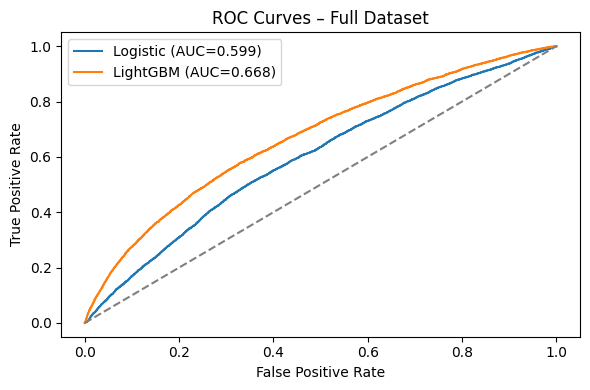

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic (AUC={lr_roc:.3f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC={lgb_roc:.3f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title('ROC Curves – Full Dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()

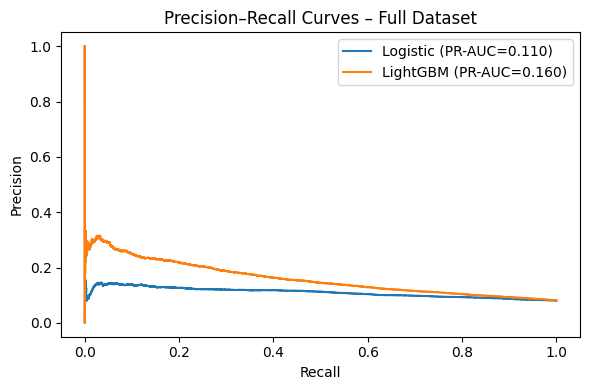

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(rec_lr, prec_lr, label=f'Logistic (PR-AUC={lr_pr:.3f})')
plt.plot(rec_lgb, prec_lgb, label=f'LightGBM (PR-AUC={lgb_pr:.3f})')
plt.title('Precision–Recall Curves – Full Dataset')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()
plt.show()

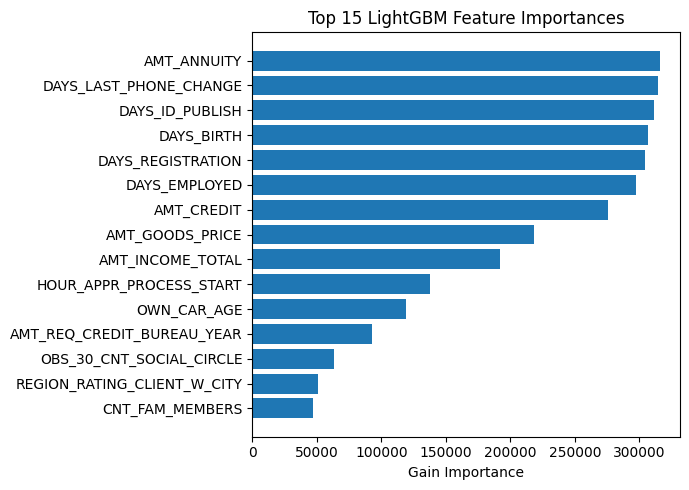

8009

In [10]:
imp = bst.feature_importance(importance_type='gain')
cols = bst.feature_name()
imp_df = pd.DataFrame({'Feature': cols, 'Importance': imp}).sort_values(by='Importance', ascending=False)
imp_df.to_csv('feature_importance.csv', index=False)

plt.figure(figsize=(7, 5))
plt.barh(imp_df['Feature'].head(15)[::-1], imp_df['Importance'].head(15)[::-1])
plt.title('Top 15 LightGBM Feature Importances')
plt.xlabel('Gain Importance')
plt.tight_layout()
plt.show()

gc.collect()